**The provided code defines a set of utility functions and a basic multilayer perceptron (MLP) network-building function using Haiku and JAX libraries for neural network development. Let's break down the code and provide an explanatory paragraph for each part:**

In [1]:
!pip install jax

In [2]:
!pip install dm-haiku

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 6.6 MB/s eta 0:00:00


In [3]:
"""Network building functions and other utilities."""

import haiku as hk
import jax
import jax.numpy as jnp
import tensorflow_datasets as tfds
import tensorflow as tf
import optax

The mlp_fn function defines a standard multilayer perceptron (MLP) neural network. It takes an input x and an optional list of hidden_sizes that specify the number of units in each hidden layer. The function first flattens the input x, then iterates through the hidden layer sizes, applying linear transformations followed by ReLU activation functions. Finally, it passes the output through a linear layer with 10 output units, which is typically used for classification tasks.

In [4]:
def neural_network(x, hidden_sizes=[1024]):
    """Standard MLP network."""

    h = hk.Flatten()(x)
    for size in hidden_sizes:
        z = hk.Linear(size)(h)
        h = jax.nn.relu(z)

    return hk.Linear(10)(h)


The sample_params function is designed to sample parameters from a Gaussian distribution specified by a prior distribution with mean (mu) and log-variance (logvar) parameters. This method employs the reparameterization trick, which is commonly used in probabilistic modeling with neural networks.

Within the function, a sub-function named sample_gaussian is defined. It takes mu and logvar as input and returns samples from a Gaussian distribution with the specified mean and log-variance. The reparameterization trick involves generating noise (eps) from a standard Gaussian distribution and then transforming it to match the desired Gaussian distribution by scaling it with the standard deviation, given by jnp.exp(logvar / 2), and adding the mean (mu).

Finally, the sample_params function applies the sample_gaussian function to each corresponding pair of mu and logvar values provided in the prior dictionary using jax.tree_map. It returns a sample from the Gaussian distribution with the same hierarchical structure as the input prior.

In [5]:
@jax.jit
def sample_params(prior, rng):
    def sample_gaussian(mu, logvar):
        return jax.random.normal(rng, shape=mu.shape) * jnp.exp(logvar / 2) + mu

    sample = jax.tree_map(sample_gaussian, prior['mu'], prior['logvar'])
    return sample

"The predict function employs a Monte Carlo sampling approach to make predictions using a neural network within a probabilistic context. It takes as input the network (net), a prior distribution (prior) for the network's parameters, a batch of input images (batch_image), a random number generator (rng), and the number of samples (num_samples) to draw from the posterior distribution. This function samples multiple sets of network parameters from the prior, computes predictions for each set of parameters, and returns the mean and standard deviation of the predicted probabilities across the sampled parameter sets.

In [6]:
def predict(net, prior, batch_image, rng, num_samples):
    probs = []
    for i in range(num_samples):
        params_rng, rng = jax.random.split(rng)
        params = sample_params(prior, params_rng)
        logits = net.apply(params, batch_image)
        probs.append(jax.nn.softmax(logits))
    stack_probs = jnp.stack(probs)
    return jnp.mean(stack_probs, axis=0), jnp.std(stack_probs, axis=0)

The code loads and preprocesses datasets using TensorFlow Datasets (TFDS). It allows users to specify the dataset name, split, whether it's for training, and the batch size. Inside the function:

- It loads the dataset using TFDS, ensuring it's loaded in a supervised format.

- The preprocess_image_label function is applied to each element of the dataset using the map function. This function converts the image data type to float32 and preserves the label.

- If the dataset is intended for training (is_training is True), it shuffles the dataset to randomize the order of samples. The buffer size for shuffling is set to 10 times the batch size for effective shuffling.

- Finally, the dataset is batched with the specified batch size, and the batches are returned as numpy arrays.

The preprocess_image_label function is defined separately to ensure consistent preprocessing of image and label pairs.

In [7]:
def load(name, split, is_training, batch_size):
    """Load and preprocess a dataset, returning batches of data."""
    dataset = tfds.load(name, split=split, as_supervised=True).cache().repeat()
    dataset = dataset.map(preprocess)

    if is_training:
        dataset = dataset.shuffle(buffer_size=10 * batch_size, seed=0)

    dataset = dataset.batch(batch_size)
    return tfds.as_numpy(dataset)

def preprocess(image, label):
    """Preprocess an image and its label."""
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label


The code sets up datasets for training and evaluating machine learning models on the MNIST dataset.

In [8]:
dataset_name = 'mnist:3.*.*'
# Create datasets for training and evaluation.
train_dataset = load(dataset_name, 'train', is_training=True, batch_size=1000)
train_eval_dataset = load(dataset_name , 'train', is_training=False, batch_size=1000)
test_eval_dataset = load(dataset_name , 'test', is_training=False, batch_size=1000)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [9]:
# Create an iterator for the train_dataset
train_iterator = iter(train_dataset)

# Draw a data batch
batch_image, batch_label = next(train_iterator)

# Print the shapes
print("Image batch shape: %s", batch_image.shape)
print("Label batch shape: %s", batch_label.shape)

Image batch shape: %s (1000, 28, 28, 1)
Label batch shape: %s (1000,)


In [10]:
# Define the neural network without applying random number generation
net = hk.without_apply_rng(hk.transform(neural_network, apply_rng=True ))

In [11]:
# Initialize model
rng = hk.PRNGSequence(42)
params = net.init(next(rng), batch_image)
prior = {
    'mu': params,  # Include the 'mu' key with appropriate values.
    'logvar': jax.tree_map(lambda x: -7 * jnp.ones_like(x), params),
}


In [12]:
# Print both keys and values
print("Keys and values in 'prior' dictionary:")
for key, value in prior.items():
    print(key)

Keys and values in 'prior' dictionary:
mu
logvar


The get_num_params function calculates the total number of parameters in a neural network. It takes a parameter tree params as input. The function flattens the parameter tree using jax.tree_flatten, which turns the hierarchical parameter structure into a flat list of arrays. It then calculates the number of parameters by summing the products of the shapes of these arrays, resulting in the total count of network parameters.

In [13]:
def get_num_params(params):
    """Returns the number of parameters in the network."""
    num_params = 0
    for p in jax.tree_util.tree_leaves(params):
        if isinstance(p.shape, tuple):
            num_params += p.shape[0]
        else:
            num_params += jnp.prod(p.shape)

    return num_params


In [14]:
print('Total number of parameters: ', get_num_params(prior))

Total number of parameters:  5684


In [15]:
# Define and initialize optimizer.
opt = optax.adam(1e-3)
opt_state = opt.init(prior)

### Custom Loss Functions and Metrics

Below are custom loss functions and metrics defined for various tasks in machine learning. These functions are commonly used in training and evaluating machine learning models. The provided implementations are efficient and compatible with JAX for high-performance computations.


The formula for the KL divergence between two Gaussian distributions, P and Q, is given by:

KL(P || Q) = 0.5 * (tr(Σ_Q^(-1) * Σ_P) + (μ_Q - μ_P)ᵀ * Σ_Q^(-1) * (μ_Q - μ_P) - k + ln(|Σ_Q| / |Σ_P|))

In the case where Q is a standard Gaussian distribution (μ_Q = 0, Σ_Q = I), this formula simplifies to:

KL(P || Q) = 0.5 * (tr(Σ_P) + μ_Pᵀ * μ_P - k - ln(|Σ_P|))

In [16]:
import jax
import jax.numpy as jnp

@jax.jit
def accuracy(logits, targets):
    """Calculate accuracy given logits and target labels."""
    predictions = jnp.argmax(logits, axis=-1)
    return jnp.mean(predictions == targets)

@jax.jit
def softmax_cross_entropy(logits, targets):
    """Calculate softmax cross-entropy loss given logits and class targets."""
    # Generate one_hot labels from index classes
    labels = jax.nn.one_hot(targets, 10)

    softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits)) / labels.shape[0]
    return softmax_xent

@jax.jit
def kl_divergence(mu, logvar):
    """Calculate KL divergence for a Gaussian distribution."""
    kl_div = jnp.sum(jnp.exp(logvar) + mu**2 - 1 - logvar) / 2
    kl_div /= mu.shape[0]
    return kl_div

In this section, we define functions for computing the Evidence Lower Bound (ELBO) and its loss, as well as an update function for stochastic gradient descent. The ELBO measures how well a probabilistic model explains the observed data. The code calculates the log-likelihood of the data and the Kullback-Leibler (KL) divergence between the approximate posterior and the prior distribution of model parameters.

In [17]:
def elbo(approx_posterior, batch, rng):
    """Computes the Evidence Lower Bound."""
    batch_image, batch_label = batch
    params = sample_params(approx_posterior, rng) # Sample net parameters from the approximate posterior.
    logits = net.apply(params, batch_image)
    log_likelihood = -softmax_cross_entropy(logits, batch_label)
    # Calculate the KL divergence for each component
    kl_div_list = jax.tree_map(kl_divergence,  approx_posterior['mu'], approx_posterior['logvar'])
    kl_d = jax.tree_util.tree_reduce(jnp.add, kl_div_list)
    elbo_ = log_likelihood - 0.001 * kl_d
    return elbo_, log_likelihood, kl_d

def loss(params, batch, rng):
    """Computes the Evidence Lower Bound loss."""
    return -elbo(params, batch, rng)[0]

@jax.jit
def update(params, opt_state, batch, rng):
    grads = jax.grad(loss)(params, batch, rng)
    updates, opt_state = opt.update(grads, opt_state)
    posterior = optax.apply_updates(params, updates)  # Apply the updates to the parameters.
    return posterior, opt_state


In [18]:
n_steps = 1000

In [19]:
elbo_losses_arr = []
accuracy_arr = []
log_likelihood_arr = []
kl_divergence_arr = []

In [20]:
"""Calculates Loss, accuracy on given dataset"""
def evaluate_performance(train_eval_dataset, params, rng, it):
  data = next(iter(train_eval_dataset))
  images, labels = data
  probs = predict(net, params, images, next(rng), 10)[0]
  elbo_, log_likelihood, kl_divergence = elbo(params, data, next(rng))
  mean_aprx_evidence = jnp.exp(elbo_ / 10)

  # Append the values to the arrays
  elbo_losses_arr.append(float(elbo_))
  accuracy_arr.append(float(accuracy(probs, labels)))
  log_likelihood_arr.append(float(log_likelihood))
  kl_divergence_arr.append(float(kl_divergence))

  print(
    f'iteration: {it}',
    f'accuracy: {float(accuracy(probs, labels)):.5f}',
    f'elbo: {float(elbo_):.5f}',
    f'log_likelihood: {float(log_likelihood):.5f}',
    f'kl_divergence: {float(kl_divergence):.5f}',
    f'mean_approximate_evidence: {float(mean_aprx_evidence):.5f}'
  )

In [21]:
step = 0
while True:
  # Do SGD on a batch of training examples.
  if step % 20 == 0:
    evaluate_performance(train_eval_dataset, prior, rng, step)
  if step == n_steps:
    break
  step = step + 1
  kwargs = dict(params=prior,
            opt_state=opt_state,
            batch=next(train_iterator))

  kwargs['rng'] = next(rng)
  prior, opt_state = update(**kwargs)


iteration: 0 accuracy: 0.12000 elbo: -5.56209 log_likelihood: -2.45310 kl_divergence: 3108.98438 mean_approximate_evidence: 0.57338
iteration: 20 accuracy: 0.84200 elbo: -3.78704 log_likelihood: -0.68258 kl_divergence: 3104.46484 mean_approximate_evidence: 0.68475
iteration: 40 accuracy: 0.86600 elbo: -3.57164 log_likelihood: -0.47170 kl_divergence: 3099.93579 mean_approximate_evidence: 0.69966
iteration: 60 accuracy: 0.89900 elbo: -3.43733 log_likelihood: -0.34204 kl_divergence: 3095.29541 mean_approximate_evidence: 0.70912
iteration: 80 accuracy: 0.92500 elbo: -3.38655 log_likelihood: -0.29597 kl_divergence: 3090.58472 mean_approximate_evidence: 0.71273
iteration: 100 accuracy: 0.93800 elbo: -3.34150 log_likelihood: -0.25570 kl_divergence: 3085.80103 mean_approximate_evidence: 0.71595
iteration: 120 accuracy: 0.94200 elbo: -3.35332 log_likelihood: -0.27236 kl_divergence: 3080.95996 mean_approximate_evidence: 0.71510
iteration: 140 accuracy: 0.94700 elbo: -3.29439 log_likelihood: -0.2

In [22]:
# Negate the values using list comprehension
neg_elbo_loss_arr = [-x for x in elbo_losses_arr]
neg_log_likelihood_arr = [-x for x in log_likelihood_arr]

In [23]:
iteration_list = list(range(0, 1001, 20))

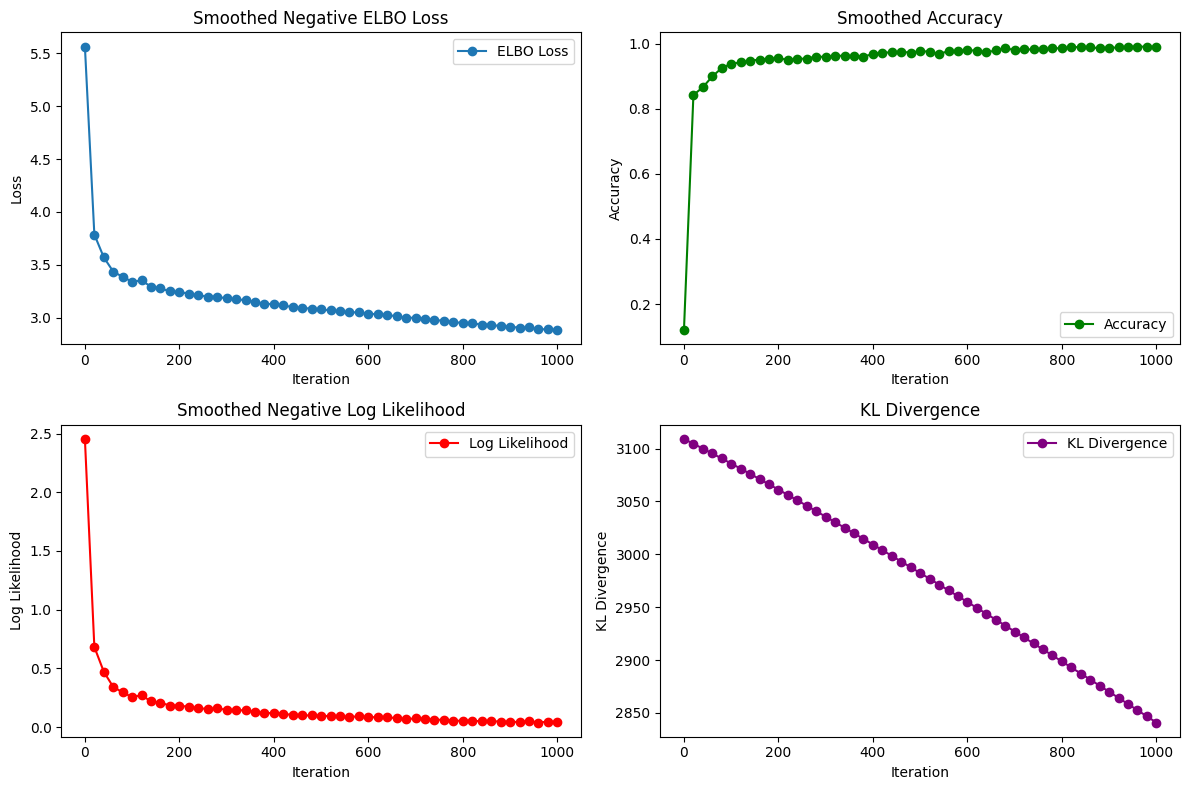

In [24]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot ELBO losses
axs[0, 0].plot(iteration_list, neg_elbo_loss_arr, label='ELBO Loss', marker='o')
axs[0, 0].set_title('Smoothed Negative ELBO Loss')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Loss')

# Plot Accuracy
axs[0, 1].plot(iteration_list, accuracy_arr, label='Accuracy', marker='o', color='green')
axs[0, 1].set_title('Smoothed Accuracy')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel('Accuracy')

# Plot Log Likelihood
axs[1, 0].plot(iteration_list, neg_log_likelihood_arr, label='Log Likelihood', marker='o', color='red')
axs[1, 0].set_title('Smoothed Negative Log Likelihood')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Log Likelihood')

# Plot KL Divergence
axs[1, 1].plot(iteration_list, kl_divergence_arr, label='KL Divergence', marker='o', color='purple')
axs[1, 1].set_title('KL Divergence')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].set_ylabel('KL Divergence')

# Add legends
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [27]:
evaluate_performance(train_eval_dataset, prior, rng, step)

iteration: 1000 accuracy: 0.98700 elbo: -2.88892 log_likelihood: -0.04794 kl_divergence: 2840.97729 mean_approximate_evidence: 0.74909


In [28]:
evaluate_performance(test_eval_dataset, prior, rng, step)

iteration: 1000 accuracy: 0.97900 elbo: -2.91372 log_likelihood: -0.07274 kl_divergence: 2840.97729 mean_approximate_evidence: 0.74724


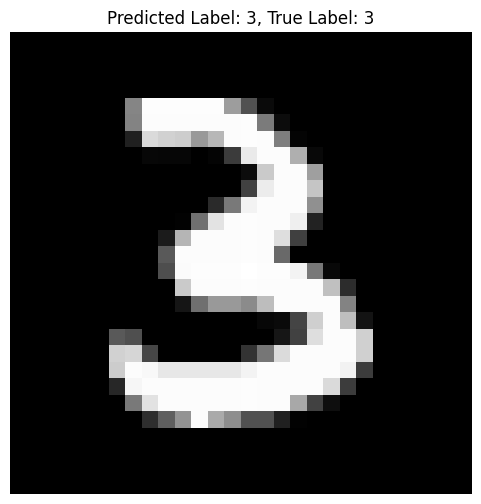

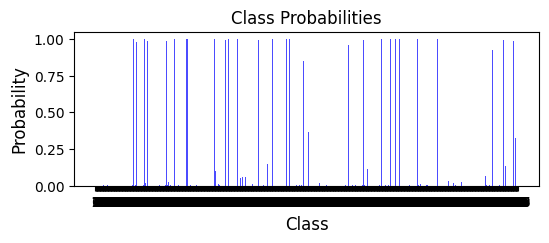

True Label: 3


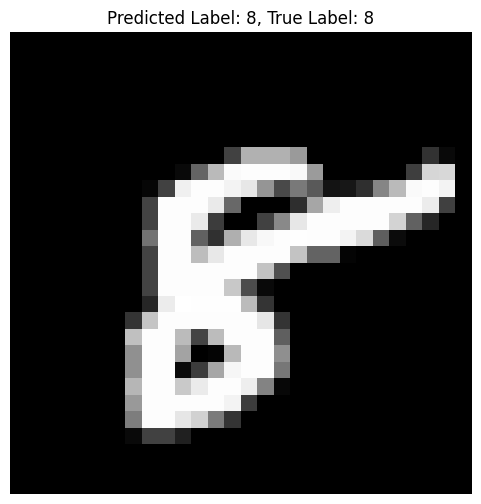

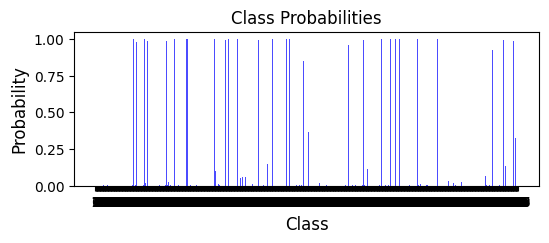

True Label: 8


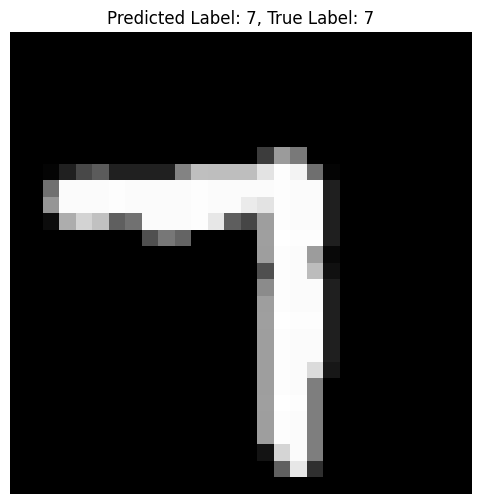

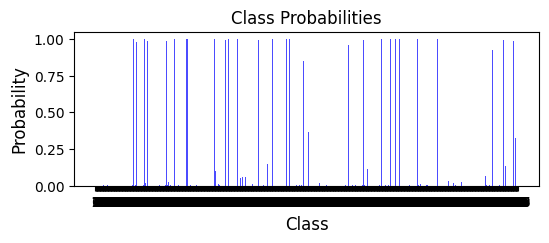

True Label: 7


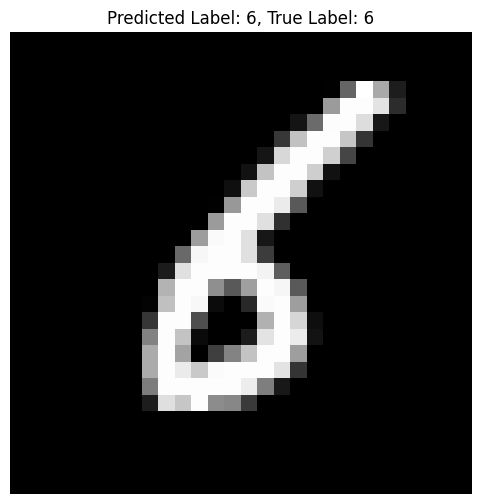

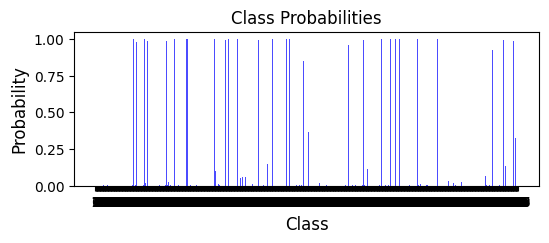

True Label: 6


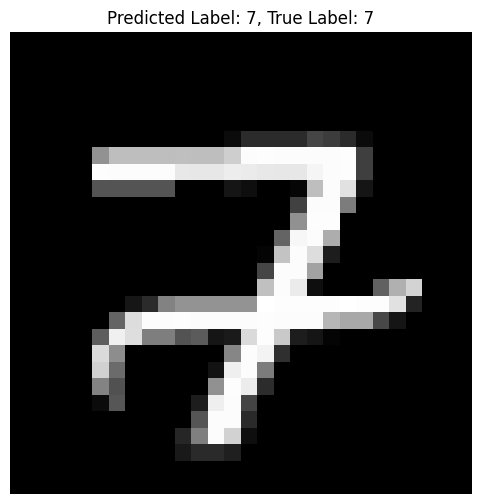

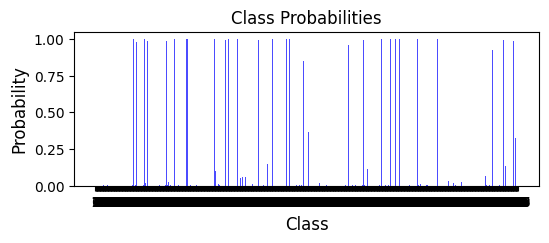

True Label: 7


In [56]:
import random
import matplotlib.pyplot as plt

# Randomly select 5 samples from the test_eval_dataset
sample_indices = [random.randint(0, 999) for _ in range(5)]

# Get a data batch from the test_eval_dataset
data = next(iter(test_eval_dataset))
images, labels = data

# Predict class probabilities using the BNN
probs = predict(net, prior, images, next(rng), 10)[0]

# Calculate the predicted labels
predicted_labels = np.argmax(probs, axis=-1)

for index in sample_indices:

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(images[index], cmap='gray')
    plt.title(f'Predicted Label: {predicted_labels[index]}, True Label: {labels[index]}', fontsize=12)
    plt.axis('off')
    plt.show()

    # Print class probabilities
    class_probs = probs[:, index]
    classes = np.arange(len(class_probs))

    plt.figure(figsize=(6, 2))
    plt.bar(classes, class_probs, color='blue', alpha=0.7)
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.title('Class Probabilities', fontsize=12)
    plt.xticks(classes, fontsize=10)
    plt.show()

    # Print the true label
    print("True Label:", labels[index])
